# Final Project for DTSA-5511
Kevin Juandi <br>
25.02.2024 <br>
https://github.com/Chiuchiyin/Facial-Keypoints-Detection

In this project I will be working through the [Facial Kepoints Detection Kaggle Competition](https://www.kaggle.com/competitions/facial-keypoints-detection/overview) and build a convolutional nueral network (CNN) to perform facial recognition. I chose this project because I am very interested in computer vision so the more exposure I get to various aspects of computer vision the better. In this project, I will use a supervised deep learning model to identify key features in faces. The benefit of working through a Kaggle competition is the ability to learn from others who have submitted open-source code to the competition, and receive immediate feedback from Kaggle on the performance of my model. 

Here is the general working plan:

1) Download, Import, and Inspect the data

2) Clean the data

3) Perform EDA

4) Build an initial CNN, evaluate it against validation

5) Submit CNN predictions to Kaggle

6) Conclusion

Before running this notebook, please ensure that you have all the necessary libraries installed. Also please use a kernel with a GPU enabled, otherwise the training time will be overwhelming. Thank you for your time, and I hope you enjoy my project.

## Loading dependancies

In [1]:
%%time
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.layers import LeakyReLU
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)
import sys
import shutil
sys.version

CPU times: total: 1.72 s
Wall time: 6.49 s


'3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]'

In [2]:
%%time
tf.__version__

CPU times: total: 0 ns
Wall time: 0 ns


'2.10.0'

In [3]:
%%time
tf.config.list_physical_devices('GPU')

CPU times: total: 78.1 ms
Wall time: 240 ms


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
%%time
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    if tf.test.is_gpu_available():
        print("GPU is available.")
        !nvidia-smi
    else:
        print("Training on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available.
Sun Feb 25 18:05:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.52                 Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   54C    P0             34W /  115W |     673MiB /   8192MiB |      9%      Default |
|                                        

## Importing the data and data cleaning

Here I am using Kaggle's API to download the data for this project. If you haven't already installed the API, just call "!pip install kaggle" in a new cell. Alternatively you can run a notebook through Kaggle's cloud computing resource, which has the benefit of allowing the user free access to GPU runtime. This is a good option if your graphics card is not compatible with TensorFlow. Before downloading the data, please ensure that your working directory is set how you'd like it for this project. You can unzip the data with shutil package. Remember to download API token first from your kaggle user settings page and place it in the right folder.

In [5]:
%%time
os.getcwd()

CPU times: total: 0 ns
Wall time: 0 ns


'E:\\Facial-Keypoints-Detection'

In [6]:
%%time
!kaggle competitions download -c facial-keypoints-detection

facial-keypoints-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
CPU times: total: 15.6 ms
Wall time: 1.46 s


In [7]:
%%time
#unzip the zip file
shutil.unpack_archive("facial-keypoints-detection.zip", "./data", "zip") 
print("Archive file unpacked successfully.")

Archive file unpacked successfully.
CPU times: total: 31.2 ms
Wall time: 4.11 s


In [8]:
%%time
#Confirm contents of "./data"
os.listdir("./data")

CPU times: total: 0 ns
Wall time: 0 ns


['IdLookupTable.csv',
 'SampleSubmission.csv',
 'test.zip',
 'training.zip',
 'training.csv',
 'test.csv']

In [9]:
%%time
#unzip the zip file
shutil.unpack_archive("./data/training.zip", "./data/", "zip")
shutil.unpack_archive("./data/test.zip", "./data/", "zip")
print("Archive file unpacked successfully.")

Archive file unpacked successfully.
CPU times: total: 266 ms
Wall time: 8.97 s


In [10]:
%%time
training_df = pd.read_csv("./data/training.csv")
testing_df = pd.read_csv("./data/test.csv")
lookup_df = pd.read_csv("./data/IdLookupTable.csv")

CPU times: total: 3.03 s
Wall time: 3.2 s


Let us now do some basic inspection of our data

In [11]:
%%time
training_df.describe()

CPU times: total: 31.2 ms
Wall time: 43.7 ms


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,...,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,...,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,...,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,...,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,...,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,...,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,...,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,...,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


In [12]:
%%time
training_df.head(1)

CPU times: total: 0 ns
Wall time: 0 ns


,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...


In [13]:
%%time
testing_df.head(1)

CPU times: total: 0 ns
Wall time: 0 ns


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


In [41]:
%%time
print("The total memory requirement for the training data is:", os.path.getsize("./data/training.csv")/1e6, "MB")
print("The total memory requirement for the testing data is:", os.path.getsize("./data/test.csv")/1e6, "MB")

The total memory requirement for the training data is: 238.06481 MB
The total memory requirement for the testing data is: 59.822141 MB
CPU times: total: 0 ns
Wall time: 2.89 ms


The data for this project is very messy. The data encodes greyscale images of faces, but are confusingly stored in .csv files. We will need to clean them. Greyscale image data are generally encoded as values indicating the brightness of individual pixels, unlike RGB images which require three dimensions per pixel. Unfortunately, the image data themselves are written as a single string sequence of numbers. Here is a snip of the test dataset for clarification:

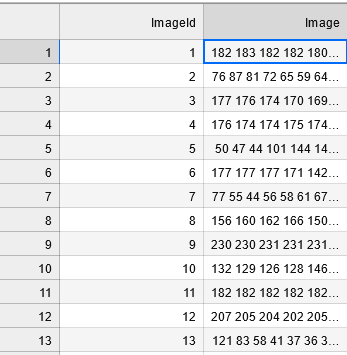

We will need to build a custom parser to turn the training and testing data into a numpy ndarray to feed to keras. The training dataset is a little bit more rectangular, because it also includes all the labels that we want to find. That said, it does still have the issue of requiring a parser for the image data. One side note: in general when doing computer vision a user is given a bunch of actual photos. A great library for converting photos to workable image data is cv2, whose imread and resize methods are fabulous conversion tools to get data into a numpy.ndarray.

Before we rectangularize the datasets, lets first check for null values in the training data. The pd.DataFrame.info() method is an excellent way to see where null values are in a data frame.

In [15]:
%%time
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   left_eye_center_x          7039 non-null   float64
 1   left_eye_center_y          7039 non-null   float64
 2   right_eye_center_x         7036 non-null   float64
 3   right_eye_center_y         7036 non-null   float64
 4   left_eye_inner_corner_x    2271 non-null   float64
 5   left_eye_inner_corner_y    2271 non-null   float64
 6   left_eye_outer_corner_x    2267 non-null   float64
 7   left_eye_outer_corner_y    2267 non-null   float64
 8   right_eye_inner_corner_x   2268 non-null   float64
 9   right_eye_inner_corner_y   2268 non-null   float64
 10  right_eye_outer_corner_x   2268 non-null   float64
 11  right_eye_outer_corner_y   2268 non-null   float64
 12  left_eyebrow_inner_end_x   2270 non-null   float64
 13  left_eyebrow_inner_end_y   2270 non-null   float

In [16]:
%%time
training_df.isnull().sum()

CPU times: total: 0 ns
Wall time: 4.86 ms


left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

All but three of the columns in the training set have null values. Moreover, there are lots of features that only have values for $\frac{2271}{7049} \times 100\% = 32.2\%$ of their observations. The lack of labels would generally make these observations useless, but removing approximately seventy percent of our dataset is inane. We should instead use an imputation method. The pandas.fillna() method supplies us with a few different ways of imputing labels. We could either forward-fill or back-fill labels from the last/next valid observation using fillna(), which is akin to selecting a random legal value from the feature's probability density function. Another good method is to impute the mean value into each missing value.

When considering methods of imputation, it is critical to consider the modelling techniques that will be employed on the data. We will be feeding the training data into a CNN attatched to an ANN. A worst case scenario is that the ANN learns to simply predict the mean value for each imputed label because it was by far the most prevalent (mode) observation in the training set. As such in order to protect the diversity of our data, I will employ a back-fill imputation rather than a mean value imputation. After backfilling I will forward fill to take care of possible last-index missing value issues. One concern is that the missing values are not evenly spaced, and so we may have large counts of replicated labels. This is unlikely, but we can shuffle the data before imputing to avoid any potential issues with non-independent rows.

In [17]:
%%time
#Randomly shuffle rows, then reset row indecies
training_df.sample(frac=1).reset_index(drop=True)
#Impute missing values
#Citation https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
training_df.fillna(method = "bfill", inplace = True)
training_df.fillna(method = "ffill", inplace = True)
#Count columns with the condition "is any element in the feature null?"
training_df.isnull().any().value_counts()

CPU times: total: 0 ns
Wall time: 12.8 ms


False    31
dtype: int64

We have succeeded in imputing random valid values into the training data. Now we need to fix the image data and load it into a numpy.ndarray for Keras. 

Cleaning note: within the image feature, there are missing values recorded as null characters, i.e. ''. To clean these I'll go ahead and map them to the mean value for a grayscale picture, 128. These missing values aren't common, so I'm not too concerned that the ANN will start just guessing 128.

In [18]:
%%time
def cleanImages(images_series : pd.Series) -> np.ndarray:
    # This function will be used on both the training and test image data to convert to np.ndarray
    imgs = list()
    
    for img in images_series:
        #Split the images using a space as seperator. split() returns a list.
        these_pix_chrs = img.split(" ")
        #Convert data type to float from character. We want float b/c we will be normalizing.
        these_pix_vals = [float(128) if j == "" else float(j) for j in these_pix_chrs]
        imgs.append(these_pix_vals)

    # Convert images from list to numpy.ndarray
    np_images = np.array(imgs)
    #shape =  (n_obs, 9216). 9216 is a perfect square b/c we have square images :) 
    ## We want one channel images to feed into Keras, ergo the following reshape:
    np_images = np_images.reshape((-1, 96, 96, 1))
    return(np_images)

CPU times: total: 0 ns
Wall time: 0 ns


In [19]:
%%time
training_images = cleanImages(training_df["Image"])
print("The resulting numpy.ndarray for the training data has shape:", training_images.shape)

The resulting numpy.ndarray for the training data has shape: (7049, 96, 96, 1)
CPU times: total: 14.8 s
Wall time: 15.9 s


In [20]:
%%time
testing_images = cleanImages(testing_df["Image"])
print("The resulting numpy.ndarray for the test data has shape:", testing_images.shape)

The resulting numpy.ndarray for the test data has shape: (1783, 96, 96, 1)
CPU times: total: 3.69 s
Wall time: 3.89 s


The last piece of cleaning to do is to extract the keypoints into a parallel numpy.ndarray to overlay the training images. We only need to do this for the training data, but I'll put it in a function anyways for future projects with similarly messy data.

In [21]:
%%time
def getKeypoints(training_data : pd.DataFrame) -> np.ndarray:
    #Extract keypoints from training data
    ## The keypoint features are all features in the training dataset that aren't the image data
    training_data = training_data.drop("Image", axis = 1)
    keypoints = list()
    
    for index, string_keypoints in training_data.iterrows():
        keypoints.append(string_keypoints)
        
    #Convert keypoints to float, and store in ndarray
    keypoints = np.array(keypoints, dtype = "float")
    
    return(keypoints)

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
%%time
training_keypoints = getKeypoints(training_df)
print("The resulting numpy.ndarray has shape:", training_keypoints.shape)

The resulting numpy.ndarray has shape: (7049, 30)
CPU times: total: 203 ms
Wall time: 313 ms


## EDA and Augmentation
Let's see a couple faces overlaid with keypoints from the training data.

CPU times: total: 15.6 ms
Wall time: 52.4 ms


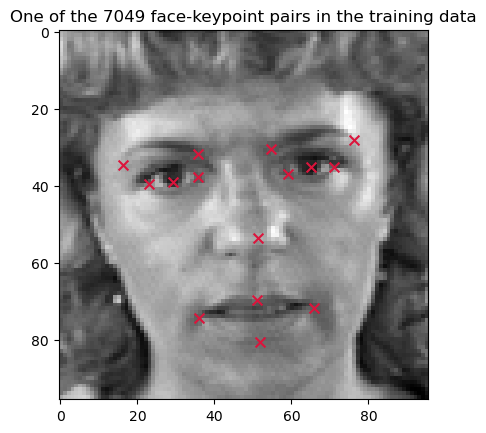

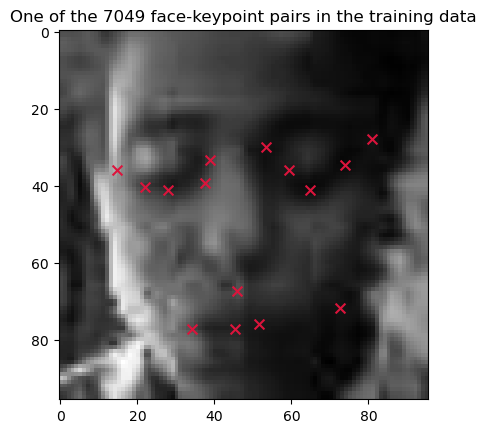

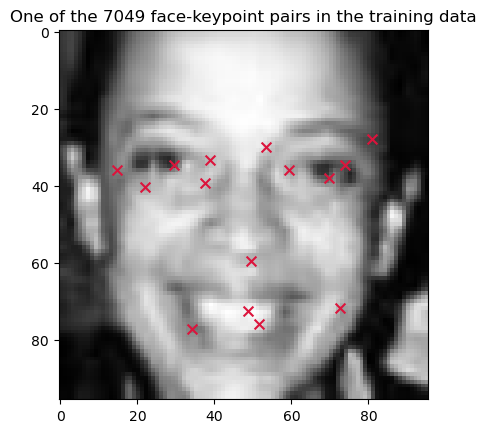

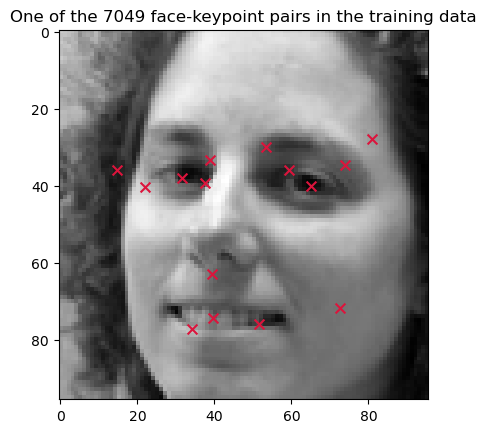

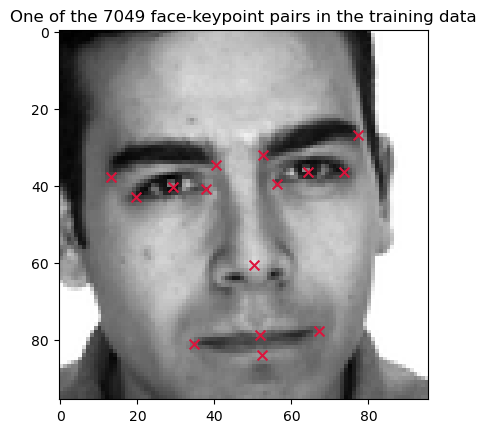

In [23]:
%%time
import random 

for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

Some of the keypoints are innacurate because they are imputed from other data. Over the course of a huge number of training data and weight updates, hopefully these misses average out to an accurate prediction.

In lecture we learned that a good way to train a nueral network to generalize the distribution of image data is to feed it different possible orientations of images it could recieve. People pose for photographs in many different positions, so we should make our model prepared for any orientation possible. Clarification - we will augment our dataset with rotations and translations of the initial dataset. As the images are rotated and translated, we will of course apply the same map to the keypoints.

In [24]:
%%time
# Make image and keypoint rotation augmenter
# Augmentation functions thanks to Kaggle user balraj98
import cv2
import math

def rotationAugment(train_imgs : np.ndarray, train_keys : np.ndarray, rotationAngles : list):
    """
        This function rotates the inputs. We will use np.concatenate to augment the training data.
        The rotations performed are both clockwise and anticlockwise in degrees, read from rotationAngles. 
        
        Output: (np.ndarray rotated_imgs, np.ndarray rotated_keys)
    """
    rotated_imgs = list()
    rotated_keys = list()
    
    for abs_theta in rotationAngles:
        both_directions = [-abs_theta, abs_theta]
        for theta in both_directions:
            # Convert angle in degrees to radians. cv2 apparantly uses a non-conventional 
            ## rotation convention where clockwise is positive, so we need a negative.
            theta_in_radians = -1 * theta * math.pi / 180
            #Create rotation matrix for warpAffine
            R = cv2.getRotationMatrix2D((48, 48), theta, 1.0) 
            
            #Rotate all training images
            for img in train_imgs:
                this_rotated_img = cv2.warpAffine(img, R, (96, 96), flags = cv2.INTER_CUBIC)
                rotated_imgs.append(this_rotated_img)
            
            #Rotate all training keypoints
            for keypts in train_keys:
                # We cant just rotate every pixel against the cv2 MAT for the keypoints,
                ## so we will need to do this manually. First, we center the keypoints about 0.
                rotated = keypts - 48
                # Next we take advantage of some trigonometry to build a point-mapper.
                for index in range(0, len(rotated), 2):
                    rotated[index] = rotated[index] * math.cos(theta_in_radians) - rotated[index + 1] * math.sin(theta_in_radians)
                    rotated[index + 1] = rotated[index + 1] * math.cos(theta_in_radians) + rotated[index] * math.sin(theta_in_radians)
                    #Un-translate so we don't have negative x-vals for the keypoints
                rotated = rotated + 48
                
                rotated_keys.append(rotated)
    
    rotated_imgs = np.array(rotated_imgs)
    rotated_imgs = rotated_imgs.reshape(-1, 96, 96, 1)
    rotated_keys = np.array(rotated_keys)
    
    return (rotated_imgs, rotated_keys)

CPU times: total: 15.6 ms
Wall time: 50.6 ms


In [25]:
%%time
# Perform rotation by -15, 15 degrees.
rotation_angles = [15]
(rotated_train_imgs, rotated_train_keypoints) = rotationAugment(training_images, training_keypoints, rotation_angles)

# The resulting dataframe will have 5 times as many observations as we started with.
## We will combine our training dataframes so that our translations will also have a 4/5 chance to
### be rotations.
training_images = np.concatenate((training_images, rotated_train_imgs))
print("After appending the rotations, the training images has shape:", training_images.shape)
training_keypoints = np.concatenate((training_keypoints, rotated_train_keypoints))
print("After appending the rotations, the training keypoints has shape:", training_keypoints.shape)

After appending the rotations, the training images has shape: (21147, 96, 96, 1)
After appending the rotations, the training keypoints has shape: (21147, 30)
CPU times: total: 2.94 s
Wall time: 3.01 s


For the sake of EDA, let's look at some of the new augmented training_images. There are now five copies of each image, with rotations on the set $\{-15, 0, 15\}$ degrees. Hopefully these mild rotations reflect what the model might encounter in the training data. As I did before, I'll pull five random photos to plot.

CPU times: total: 93.8 ms
Wall time: 106 ms


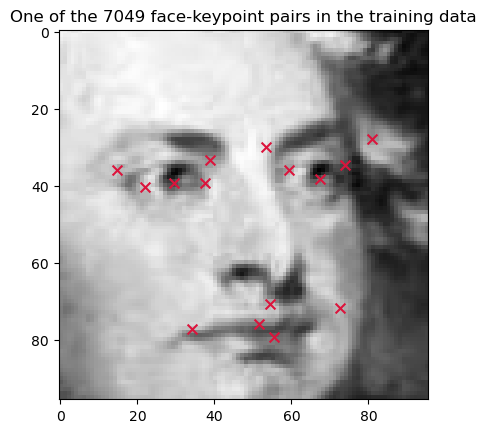

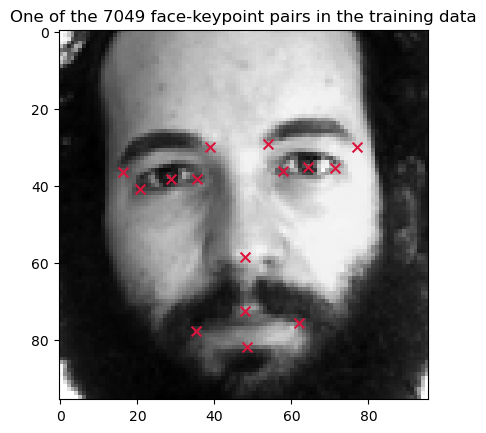

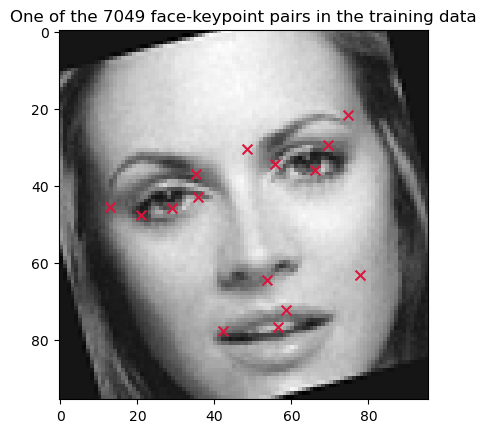

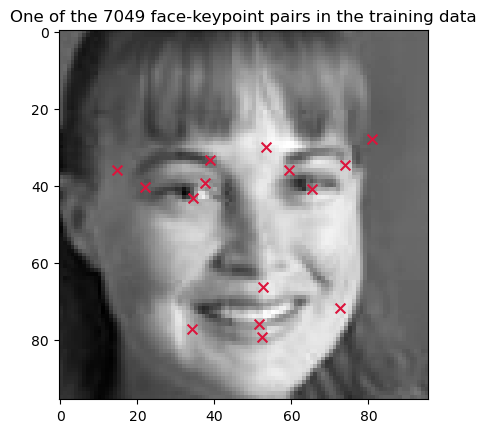

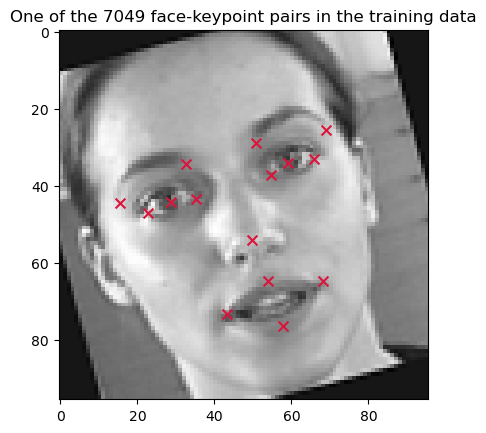

In [26]:
%%time
for i in range(5):
    idx = random.randrange(0, training_images.shape[0])
    fig, axis = plt.subplots()
    this_img = training_images[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(training_keypoints[idx][0::2], training_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 7049 face-keypoint pairs in the training data")

We will limit the amount of training data that the model encounters. We want to include all the "normal" images because they are most representative of what we are likely to encounter in the test set. I will include about 8000 augmented images, randomly selected as well.

In [27]:
%%time
#Citation https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison

n_augmented_samples = 15000 - 7049
normal_imgs = training_images[:7049, :, :, :]
normal_keypts = training_keypoints[:7049, :]
augmented_indecies = [i for i in range(7049, training_images.shape[0])]
p = np.random.permutation(augmented_indecies)
augmented_imgs = training_images[p, :, :, :]
augmented_keypts = training_keypoints[p, :]

training_images = np.concatenate((normal_imgs, augmented_imgs[:n_augmented_samples, :, :, :]))
training_keypoints = np.concatenate((normal_keypts, augmented_keypts[:n_augmented_samples, :]))

CPU times: total: 578 ms
Wall time: 783 ms


In [28]:
%%time
print("The final training image set has shape:", training_images.shape)
print("The final training keypoint set has shape:", training_keypoints.shape)

The final training image set has shape: (15000, 96, 96, 1)
The final training keypoint set has shape: (15000, 30)
CPU times: total: 0 ns
Wall time: 0 ns


## Model architecture and Construction

I believe the code is rather self explanatory

In [29]:
%%time
model = Sequential([
    Conv2D(64, (5, 5), padding='same', use_bias=False, input_shape=(96, 96, 1)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (4, 4), padding='same', use_bias=False),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(256, (3, 3), padding='same', use_bias=False),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(512, (2, 2), padding='same', use_bias=False),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(30)
])

CPU times: total: 188 ms
Wall time: 1.35 s


In [30]:
%%time
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1600      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       131072    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 128)       0

CPU times: total: 0 ns
Wall time: 406 ms


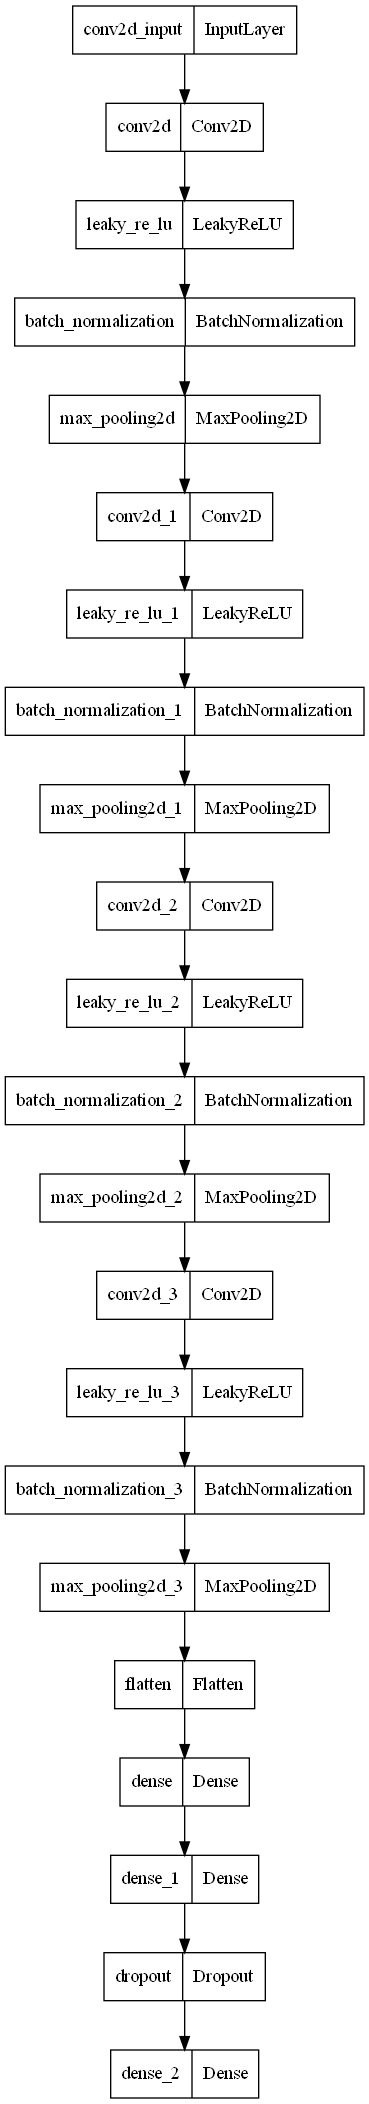

In [31]:
%%time
tf.keras.utils.plot_model(model)

In [32]:
%%time
epochs = 30
batch_size = 32
validation_split = 0.2

CPU times: total: 0 ns
Wall time: 0 ns


In [33]:
%%time
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['accuracy'])

CPU times: total: 15.6 ms
Wall time: 19.5 ms


In [34]:
%%time
x_train = training_images
y_train = training_keypoints

CPU times: total: 0 ns
Wall time: 0 ns


Training the model

In [35]:
%%time
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience = 5, mode = "min")]

history = model.fit(x_train, y_train,
                            validation_split = validation_split,
                            epochs = epochs,
                            batch_size = batch_size,
                            callbacks = callbacks_list,
                            verbose = 2
                           )

Epoch 1/30
375/375 - 21s - loss: 112.6650 - accuracy: 0.3248 - val_loss: 65.3752 - val_accuracy: 0.5100 - 21s/epoch - 55ms/step
Epoch 2/30
375/375 - 12s - loss: 46.8721 - accuracy: 0.4558 - val_loss: 15.2722 - val_accuracy: 0.4973 - 12s/epoch - 31ms/step
Epoch 3/30
375/375 - 12s - loss: 35.5185 - accuracy: 0.5179 - val_loss: 17.8635 - val_accuracy: 0.5160 - 12s/epoch - 31ms/step
Epoch 4/30
375/375 - 12s - loss: 33.5253 - accuracy: 0.5428 - val_loss: 16.6312 - val_accuracy: 0.5383 - 12s/epoch - 31ms/step
Epoch 5/30
375/375 - 12s - loss: 29.9800 - accuracy: 0.5565 - val_loss: 12.8716 - val_accuracy: 0.5140 - 12s/epoch - 31ms/step
Epoch 6/30
375/375 - 12s - loss: 29.7061 - accuracy: 0.5824 - val_loss: 24.4536 - val_accuracy: 0.5293 - 12s/epoch - 32ms/step
Epoch 7/30
375/375 - 12s - loss: 28.4516 - accuracy: 0.5956 - val_loss: 7.7076 - val_accuracy: 0.5073 - 12s/epoch - 31ms/step
Epoch 8/30
375/375 - 12s - loss: 28.0770 - accuracy: 0.6058 - val_loss: 9.0213 - val_accuracy: 0.5177 - 12s/epo

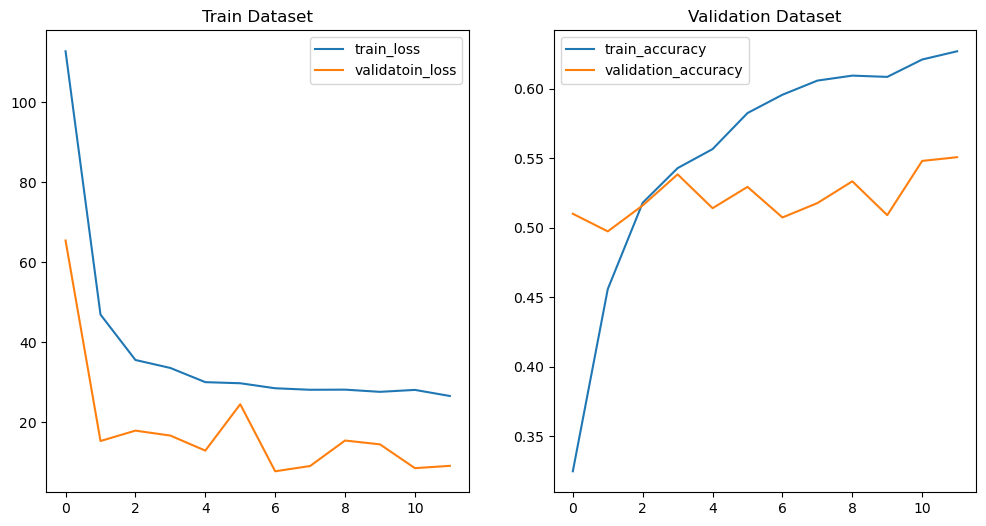

CPU times: total: 188 ms
Wall time: 311 ms


In [36]:
%%time
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train Dataset')
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='validatoin_loss')
plt.legend()
plt.subplot(1,2,2)
plt.title('Validation Dataset')
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.show()

One note on the plots: the accuracy is only recorded as a "hit" if the model outputs the exact correct pixel for the keypoint. The keypoint labels are pretty fuzzy to begin with, and a bunch of the labels were imputed from other data. A final accuracy of about 60% is quite good for pixel perfect assignments.

In [37]:
%%time
x_test = testing_images
print("The resulting numpy.ndarray for the test data has shape:", x_test.shape)

The resulting numpy.ndarray for the test data has shape: (1783, 96, 96, 1)
CPU times: total: 0 ns
Wall time: 1.26 ms


56/56 [==============================] - 1s 8ms/step
CPU times: total: 375 ms
Wall time: 918 ms


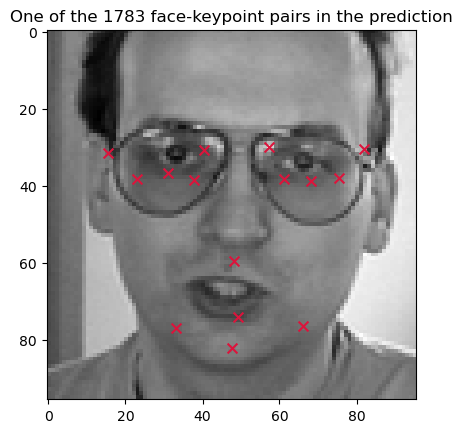

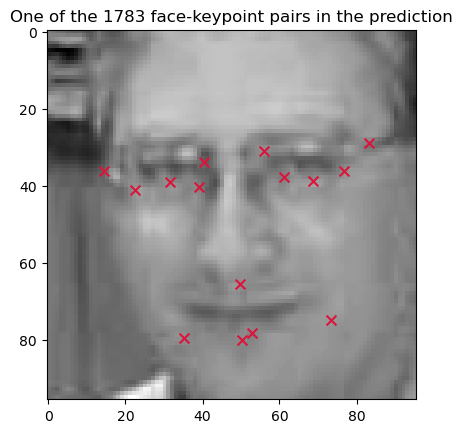

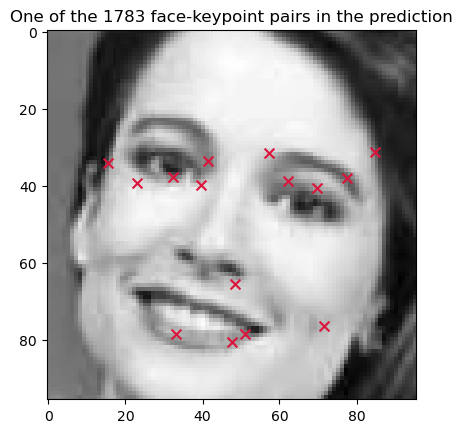

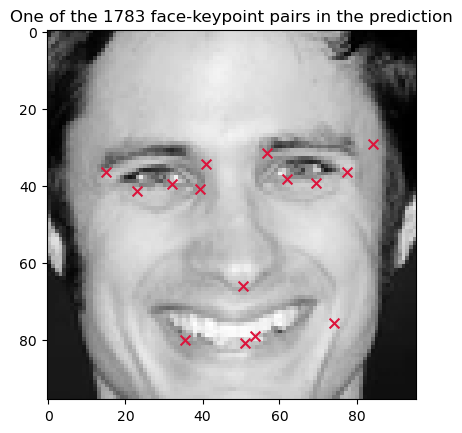

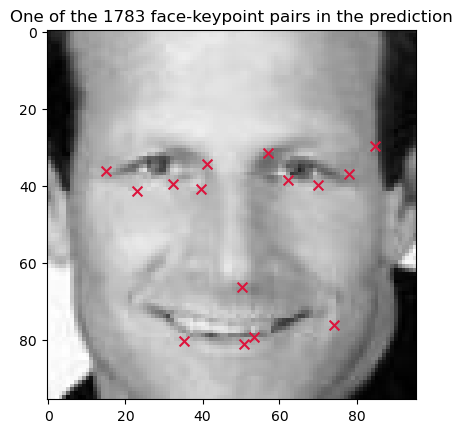

In [38]:
%%time
pred_keypoints = history.model.predict(x_test)

for i in range(5):
    idx = random.randrange(0, x_test.shape[0])
    fig, axis = plt.subplots()
    this_img = x_test[idx].reshape(96, 96)
    axis.imshow(this_img, cmap = "gray")
    axis.scatter(pred_keypoints[idx][0::2], pred_keypoints[idx][1::2], c = "crimson", marker = "x", s = 50)
    plt.title("One of the 1783 face-keypoint pairs in the prediction")

Our model appears proficient at identifying eyes and eyebrows, but it struggles with accurately recognizing noses and the boundaries of mouths. Considering this, we may achieve improved results by excluding photos with incomplete rows instead of relying on data imputation. Let's proceed to submit these results to Kaggle for evaluation.

In [39]:
%%time
lookup_df.head()

CPU times: total: 0 ns
Wall time: 4.6 ms


,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN


In [40]:
feature_names = list(lookup_df['FeatureName'])
image_ids = list(lookup_df['ImageId']-1)
row_ids = list(lookup_df['RowId'])

feature_list = [feature_names.index(feature) for feature in feature_names]
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(pred_keypoints[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
print(submission_result.shape)
submission_result.to_csv('./submission.csv',index = False)

(27124, 2)



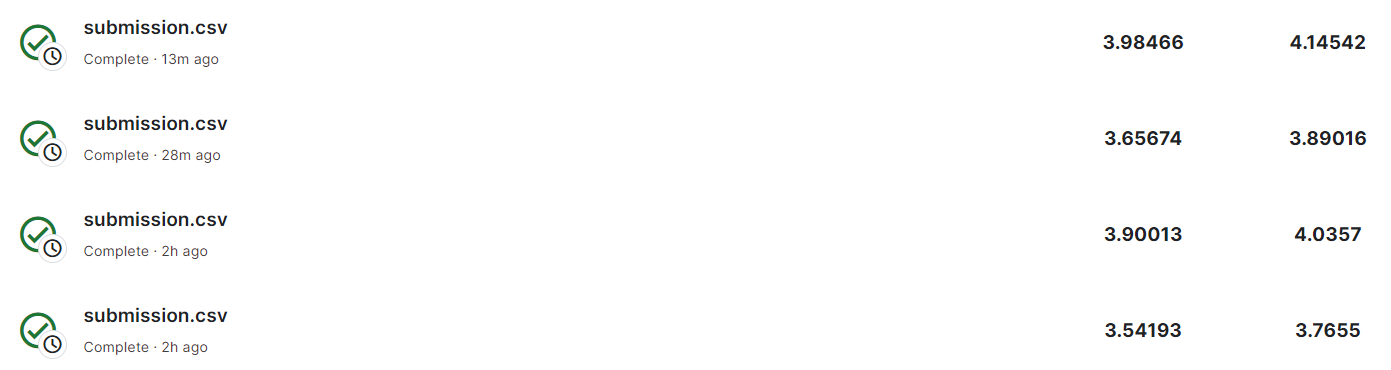


## Conclusion
Imputing null values using the current approach proves to be ineffective, as it fails to accurately determine the missing keypoints' locations. The mean values, in particular, often deviate significantly from the actual keypoint locations, as evident from the random images generated.

For enhanced precision, it is recommended to fill null values through manual examination of images. Accurate data is crucial for evaluating model performance. The existing method of imputing with the fill mean has led to inaccuracies in model outcomes, which is undesirable. Ensuring data cleanliness prior to modeling is imperative.

Given that only around 30% of the data is devoid of null values, it may be beneficial to train a model exclusively on this clean subset instead of using the entire dataset. We could perform additional geometric transformation to make up for it.